In [28]:
import sys

sys.path.append("/datavon1/Paper2data/qpac/")
from qpac.descriptors import quipSOAP
from qpac.kernel import *
from qpac.utils import *
from qpac.kQEq import kernel_qeq
from qpac.GAP import GAP
from qpac.MLmodel import MLmodel
from qpac.utils_plots import plot_basics
from ase.units import Hartree
from ase.io import read, write
import numpy as np
import random

aEs = {"H":-13.641637275,"O":-2043.796858679}

molsNeut = read("xtbneut100.xyz@:",format="extxyz")
molsPos  = read("xtbpos100.xyz@:",format="extxyz")
molsNeg = read("xtbneg100.xyz@:",format="extxyz")

In [29]:
train_set = molsNeut[:10]

In [30]:
soap_desctipor = quipSOAP(STRsoap="soap cutoff=3.0 l_max=5 n_max=6 atom_sigma=0.5 normalize=T n_species=2 species_Z={1 8} n_Z=2 Z={1 8}", species=["H","O"])
# soap_desctipor = quipSOAP(STRsoap="soap cutoff=3.0 l_max=5 n_max=6 atom_sigma=0.5 normalize=T n_species=2 species_Z={1 8} n_Z=2 Z={1 8}", species=["H","O"])

qpac_kernel = qpacKernel(Descriptors=soap_desctipor,
                         training_set=train_set,
                         training_set_charges=[a.info["total_charge"] for a in train_set],
                         sparse = True,
                         perEl = True,      
                         sparse_method = "CUR",
                         sparse_count=1000)


Computing training descriptors for for descriptor number 0
Starting CUR decomposition for each element (final number of sparse points will be number of species * sparse_count)


In [31]:
qpac_gap = GAP(Kernel=qpac_kernel)
qpac_kqeq = kernel_qeq(Kernel=qpac_kernel,
                     scale_atsize=1/np.sqrt(2.0),
                     radius_type="qeq")

qpac_ML = MLmodel(kQEqclass = qpac_kqeq,
                    GAPclass = qpac_gap)


Computed kernel for training
Kernel is done
Computed kernel for training
Kernel is done


In [36]:
qpac_ML.train( 
              targets = ["energy","forces"], 
              target_sigmas = [0.0000001,0.001], 
              charge_keyword='dft_hirshfeld',
              max_iter = 50,
              atom_energy=aEs,
              n_bad_iters = 20,
              scc_target=False,
              scc_sigma=0.1,
              energy_keyword="dft_energy",
              forces_keyword="dft_forces",
              verbose=True)

####################################################################
sigma 0.001
New RMSE: 0.021924708255553663
Old RMSE: inf
Bad RMSEs in row: 1
Sample of charges: [-0.2067811   0.12292227  0.11243202 -0.22978328  0.11048961  0.11389465
 -0.26636787  0.08847016  0.0965655  -0.13776745]
sum of charges:  -1.6653345369377348e-16
iteration 0 is done
####################################################################
New best model reached
####################################################################
sigma 0.001
New RMSE: 0.01178558540365932
Old RMSE: 0.021924708255553663
Bad RMSEs in row: 1
Sample of charges: [-0.1880567   0.07645973  0.08031132 -0.15532543  0.07869441  0.09055502
 -0.18113778  0.08134619  0.10371241 -0.18750904]
sum of charges:  2.220446049250313e-16
iteration 1 is done
####################################################################
New best model reached
####################################################################
sigma 0.001
New RMSE: 0.01102285870

In [37]:
E_test = []
q_test = []
F_test = []
for a in train_set:
    temp = qpac_ML.calculate(a,ext_field=a.info["ext_field"],charge=a.info["total_charge"])
    E_test.append(temp["energy"]/len(a))
    q_test.extend(temp["charges"])
    F_test.extend(temp["forces"].flatten())

In [38]:
ref_en_test  = get_energies_perAtom_eV(mols=train_set,atom_energy = aEs,energy_keyword="dft_energy")
ref_q_test = get_charges(mols=train_set, charge_keyword="dft_hirshfeld")
ref_f_test = get_forces_eV(mols=train_set,forces_keyword="dft_forces")

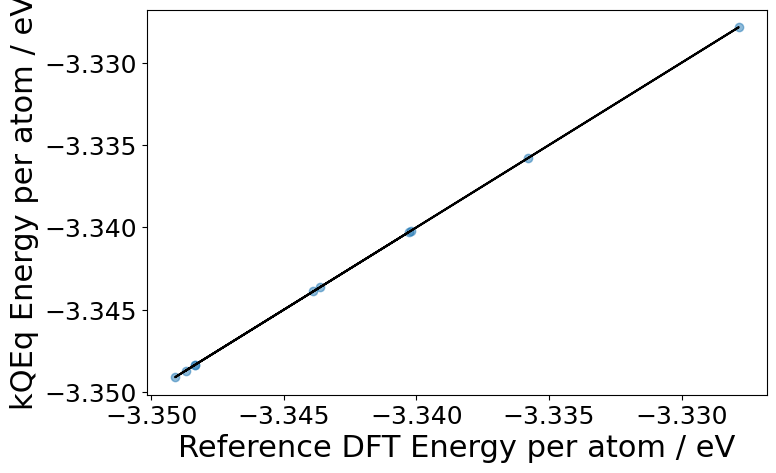

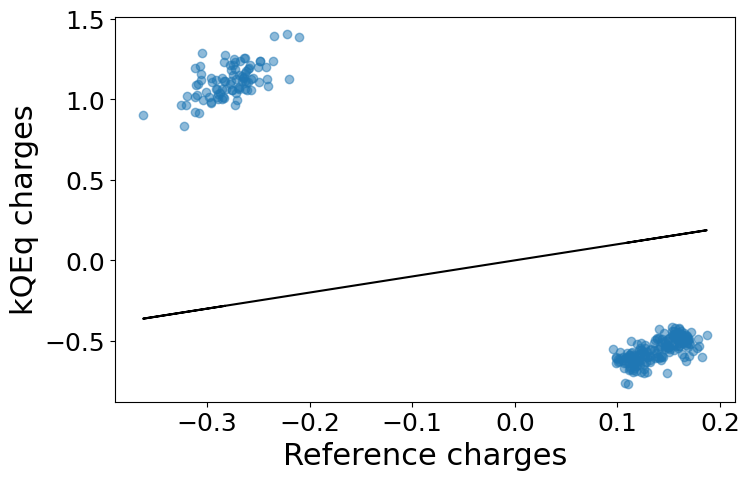

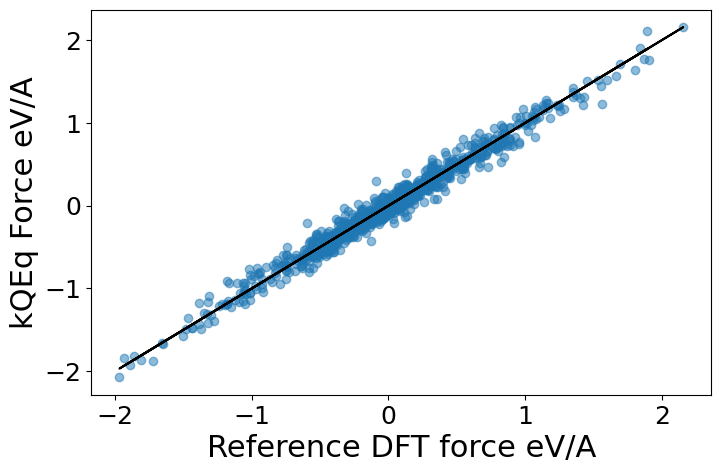

In [39]:
plot_basics(ref=ref_en_test,kqeq = E_test,preset="energy")
plot_basics(ref=ref_q_test,kqeq = q_test,preset="charges")
plot_basics(ref=ref_f_test,kqeq = F_test,preset="forces")